# Voxel VAE-GAN Training

This notebook is designed to provide a wholistic vae-gan training experience. You can adjust the model and training parameters through the sacred configuration file, you can view training progress in tensorboard, and you can (wip) create reconstructions with the saved models!

## Setup

In [1]:
import env
from train_vaegan import train_vaegan
from data.thingi10k import Thingi10k
from data.modelnet10 import ModelNet10
from data import MODELNET10_TOILET_INDEX


# plot things
%matplotlib inline
# autoreload modules
%load_ext autoreload
%autoreload 2

## Prepare Sacred Experiment

In [2]:
from sacred.observers import FileStorageObserver
from sacred import Experiment

ex = Experiment(name='voxel_vaegan_notebook', interactive=True)
ex.observers.append(FileStorageObserver.create('experiments_vaegan'))

@ex.main
def run_experiment(cfg):
    train_vaegan(cfg)

import datetime
last_model_dir = None

## Prepare Model Config

The model dir is generated with a timestamp. This keeps you from overwriting past results and keeps results separate to avoid confusing tensorboard.

But be warned! These model dirs can take up space, so you might need to periodically go back and delete ones you do not care about.

Also, if you ever train a model that you would really like to keep, I recommend moving it to a new directory with a special name like "best_model_ever".

In [30]:
def make_cfg():
    MODEL_DIR = 'voxel_vaegan1/{}'.format(datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'))
    print(MODEL_DIR)

    cfg = {
        'cfg': {
            "dataset": {
                "class": ModelNet10,
                "index": MODELNET10_TOILET_INDEX,
                #"tag": "animal",
                #"filter_id": 126660,
                #"pctile": 1.0,
                "splits": True
                #"splits": {
                #    "train": .8,
                #    "dev": .1,
                #    "test": .1
                #}
            },
            "generator": {
                "verbose": True,
                "pad": True
            }, 
            "model": {
                "ckpt_dir": MODEL_DIR,
                "voxels_dim": 32,
                "batch_size": 32,
                "example_stl_id": 126660,
                "voxel_prob_threshold": 0.065,
                "enc_lr": 0.0001,
                "dec_lr": 0.0001,
                "dis_lr": 0.0001,
                "keep_prob": 0.8,
                "kl_div_loss_weight": 1,
                "recon_loss_weight": 10000,            
                "latent_dim": 100,
                "verbose": False,
                "debug": False,
                "epochs": 10,
                "input_repeats": 1,
                "display_step": 6000,
                "dev_step": 10,
                "save_step": 10,
                'launch_tensorboard': True,
                'tb_dir': 'tb',
                'no_gan': True
            }
        }
    }
    
    return cfg

## Tensorboard Prep

We launch tensorboard with a call to the python subprocess module. Sometimes, that process does not die with the rest of the experiment and lingers on as a system process. This becomes a problem when we try to initialize tensorboard for the next experiment because they cannot share the same port!

The function below is designed to solve this problem. It uses the linux pgrep utility to search for existing tensorboard processes and kill them. Note that this probably won't work on Windows.

In [31]:
from utils import kill_tensorboard

kill_tensorboard()

['pgrep', 'tensorboard'] yielded -> b'4246\n5051\n'
killed b'4246'!
killed b'5051'!


## Training

We start with a check that we are not attempting to overwrite the last MODEL_DIR. If you are blocked by the assert, re-execute the cfg code above to generate a new MODEL_DIR. This will allow you to move ahead with training.

The sacred experiment will save away a copy of your experiment settings in an experiments directory. This can be accessed later in case we need to retrieve a prime config.

If tensorboard is enabled, tune in at localhost:6006 or your_ip:6006
   

In [35]:
cfg = make_cfg()
MODEL_DIR = cfg.get('cfg').get('model').get('ckpt_dir')
kill_tensorboard()

voxel_vaegan1/2019-03-12_16-36-25
['pgrep', 'tensorboard'] yielded -> b'5051\n5663\n'
killed b'5051'!
killed b'5663'!


In [ ]:
if last_model_dir == MODEL_DIR:
    print('dont overwrite!')
    assert False
else:
    last_model_dir = MODEL_DIR

ex.run(config_updates=cfg)

WARNING - root - Added new config entry: "cfg.dataset.class"
WARNING - root - Added new config entry: "cfg.dataset.index"
WARNING - root - Added new config entry: "cfg.dataset.splits"
WARNING - root - Added new config entry: "cfg.generator.pad"
WARNING - root - Added new config entry: "cfg.generator.verbose"
WARNING - root - Added new config entry: "cfg.model.batch_size"
WARNING - root - Added new config entry: "cfg.model.ckpt_dir"
WARNING - root - Added new config entry: "cfg.model.debug"
WARNING - root - Added new config entry: "cfg.model.dec_lr"
WARNING - root - Added new config entry: "cfg.model.dev_step"
WARNING - root - Added new config entry: "cfg.model.dis_lr"
WARNING - root - Added new config entry: "cfg.model.display_step"
WARNING - root - Added new config entry: "cfg.model.enc_lr"
WARNING - root - Added new config entry: "cfg.model.epochs"
WARNING - root - Added new config entry: "cfg.model.example_stl_id"
WARNING - root - Added new config entry: "cfg.model.input_repeats"
WA

Logging to /home/jcworkma/jack/3d-form/src/logs/2019-03-12_16-36__root.log
Starting train_vaegan main
Dataset: <class 'data.modelnet10.ModelNet10'>
Using dataset index /home/jcworkma/jack/3d-form/src/../data/processed/modelnet10_toilet_index.csv and pctile None
dataset n_input=7104
Num input = 7104
Num batches per epoch = 222.00
Initializing VoxelVaegan
Running VAE-GAN in VAE-Only Mode
['tensorboard', '--logdir', '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_16-36-25/tb']
Epoch: 0, Elapsed Time: 0.01
Epoch: 1, Elapsed Time: 4.23
Epoch: 2, Elapsed Time: 8.44
Epoch: 3, Elapsed Time: 12.70
Epoch: 4, Elapsed Time: 16.98


## Reconstructions

Here we can reload a model and experiment with reconstructions.

In [7]:
import tensorflow as tf
import numpy as np
from models.voxel_vaegan import VoxelVaegan
from data.voxels import plot_voxels

tf.reset_default_graph()

# 500 epochs, just bird
#model = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_09-30-02/model_epoch-499.ckpt'
# 500 epochs, just bird, increased recon weight
#model = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_09-38-41/model_epoch-499.ckpt'
# 500 epochs, just bird, dropout 0.8
# early stop
#model = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_09-44-48/model_epoch-199.ckpt'
# later stop
#model = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_09-44-48/model_epoch-499.ckpt'
model = '/home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_10-22-19/model_epoch-49.ckpt'

In [8]:
# restore the model from ckpt
vaegan = VoxelVaegan.initFromCfg(cfg.get('cfg'))
vaegan.restore(model)

Initializing VoxelVaegan
Running VAE-GAN in VAE-Only Mode


/home/jcworkma/jack/3d-form/.3d-form/lib/python3.5/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from /home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_10-22-19/model_epoch-49.ckpt
Restoring parameters from /home/jcworkma/jack/3d-form/src/../models/voxel_vaegan1/2019-03-12_10-22-19/model_epoch-49.ckpt


update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


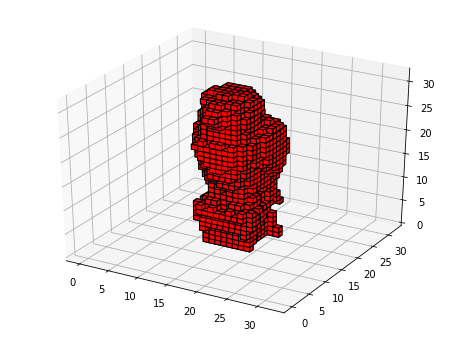

In [9]:
from data.thingi10k import Thingi10k
# get an stl example
thingi = Thingi10k.init10k()
stl_example = thingi.get_stl_path(stl_id=126660)
training_example = thingi.get_voxels(32, stl_file=stl_example)
plot_voxels(training_example)
training_example = np.reshape(training_example, (-1, 32, 32, 32, 1))

In [10]:
recon = vaegan.reconstruct(training_example)
recon = np.reshape(recon, [32, 32, 32])
print('max: ', np.max(recon))
print('min: ', np.min(recon))
print('mean: ', np.mean(recon))

max:  0.9977519
min:  3.212928e-08
mean:  0.7532493


<module 'matplotlib.pyplot' from '/home/jcworkma/jack/3d-form/.3d-form/lib/python3.5/site-packages/matplotlib/pyplot.py'>

update_title_pos
update_title_pos
update_title_pos
update_title_pos
update_title_pos


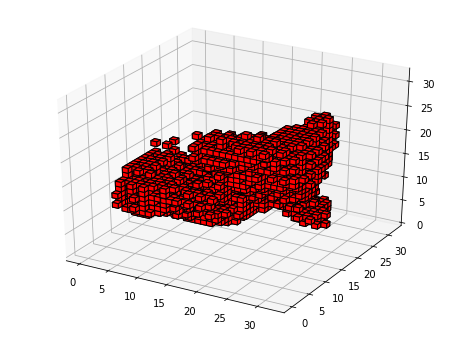

In [18]:
recon_threshold = recon > 0.985
plot_voxels(recon_threshold)